# Self-Supervised Learning CIFAR10: Using rotations as a pretext

In this tutorial, we will use self-supervised learning (SSL) to improve classification in the CIFAR10 dataset. We will use rotation classification as a pretext task. The downstream task is to predict the CIFAR10 classes.

Learning goals:

    - Use rotation as a SSL pretext to improve classification accuracy.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from scipy.ndimage import rotate

## Load dataset, explore it  and split it into train, validation and test sets

- [Load CIFAR10 Keras](https://keras.io/api/datasets/cifar10/)

In [2]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data() # The data comes already split 
                                                                        # in dev and test sets
Y_dev = Y_dev[:,0]
Y_test = Y_test[:,0]

print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (50000, 32, 32, 3)
Labels shape: (50000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 32, 32, 3)
Labels shape:  (10000,)


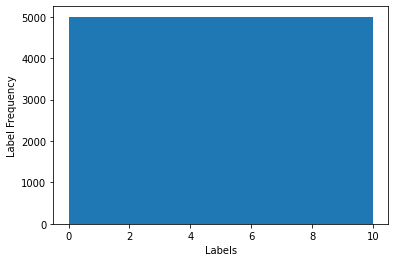

In [3]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

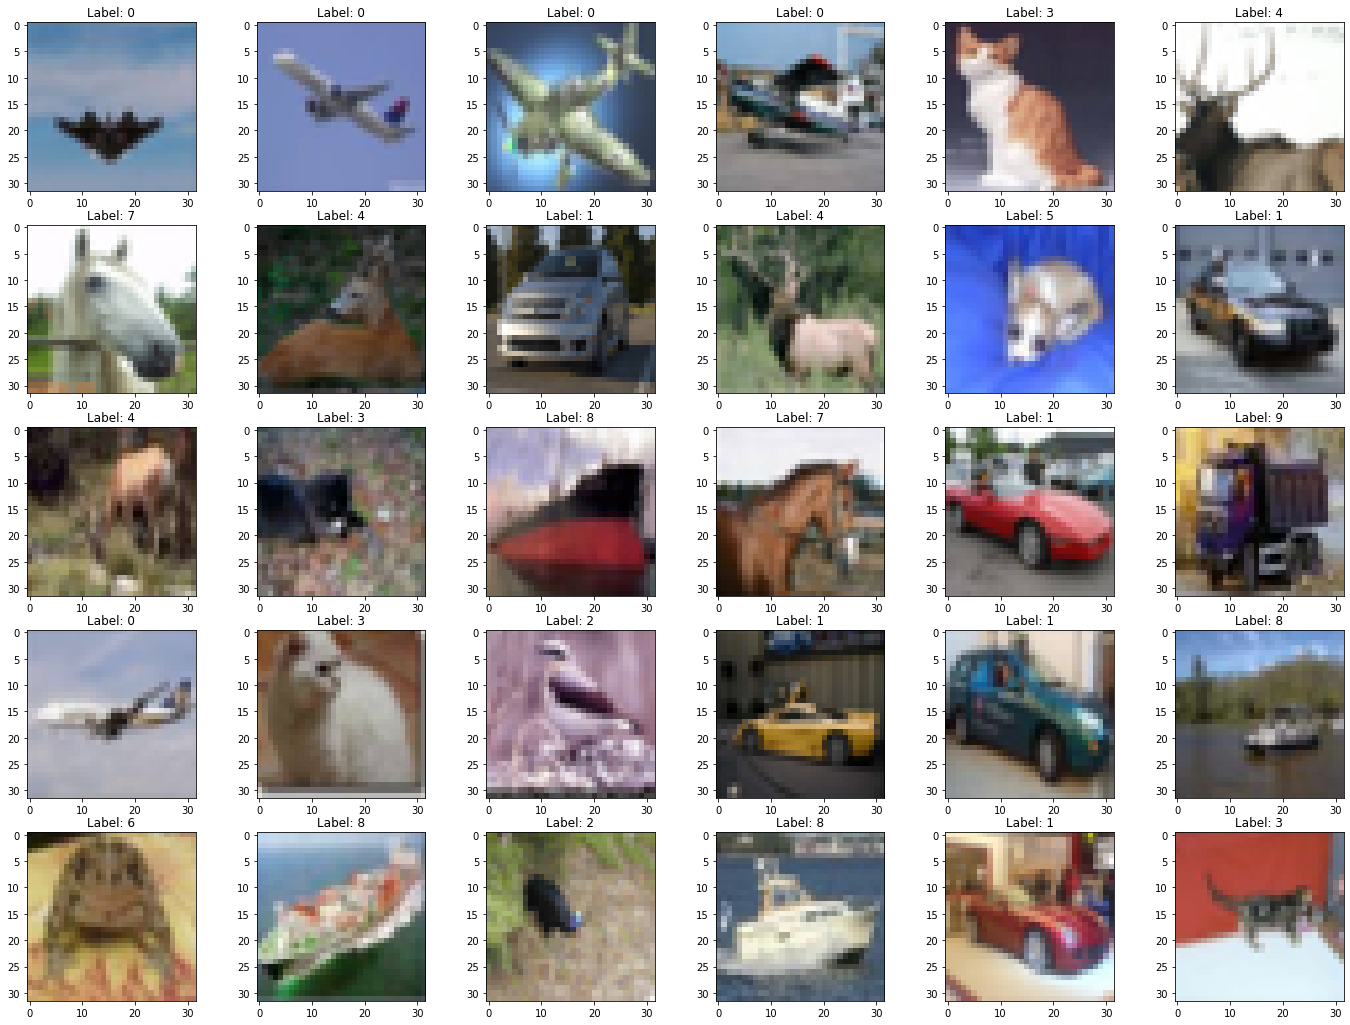

In [4]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [5]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (37500, 32, 32, 3)
Labels shape:  (37500,)

Validation set
Images:  (12500, 32, 32, 3)
Labels shape:  (12500,)


In [6]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 120.78197439236111 64.15585688403979
0 255 120.48433731770834 64.13221178861012


## 2. Data Scaling 

In [7]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. One hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[7 9 6 4 6]

One hot encoded labels:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## 4. Define your model, cost function, optimizer, learning rate

In [9]:
def my_model(ishape = (32,32,3),k = 10):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    return model

In [10]:
model = my_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics = ["accuracy"])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040 

## 5. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [11]:
model_name = "best_model_cifar10_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Train your model (no pretext)

In [12]:
model.fit(X_train,Y_train_oh,batch_size = 128, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/100
293/293 [==============================] - 49s 168ms/step - loss: 2.1034 - accuracy: 0.2377 - val_loss: 1.7017 - val_accuracy: 0.4142
Epoch 2/100
293/293 [==============================] - 49s 168ms/step - loss: 1.6208 - accuracy: 0.4228 - val_loss: 1.5639 - val_accuracy: 0.4516
Epoch 3/100
293/293 [==============================] - 49s 168ms/step - loss: 1.5092 - accuracy: 0.4686 - val_loss: 1.4686 - val_accuracy: 0.4871
Epoch 4/100
293/293 [==============================] - 49s 168ms/step - loss: 1.4125 - accuracy: 0.4998 - val_loss: 1.4063 - val_accuracy: 0.5127
Epoch 5/100
293/293 [==============================] - 49s 168ms/step - loss: 1.3649 - accuracy: 0.5136 - val_loss: 1.3596 - val_accuracy: 0.5341
Epoch 6/100
293/293 [==============================] - 49s 168ms/step - loss: 1.3034 - accuracy: 0.5411 - val_loss: 1.3183 - val_accuracy: 0.5496
Epoch 7/100
293/293 [==============================] - 49s 168ms/step - loss: 1.2639 - accuracy: 0.5525 - val_loss: 1.2826 -

Epoch 57/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9448 - accuracy: 0.6747 - val_loss: 1.0394 - val_accuracy: 0.6431
Epoch 58/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9279 - accuracy: 0.6763 - val_loss: 1.0393 - val_accuracy: 0.6429
Epoch 59/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9414 - accuracy: 0.6738 - val_loss: 1.0433 - val_accuracy: 0.6395
Epoch 60/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9337 - accuracy: 0.6767 - val_loss: 1.0390 - val_accuracy: 0.6434
Epoch 61/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9324 - accuracy: 0.6787 - val_loss: 1.0398 - val_accuracy: 0.6437
Epoch 62/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9357 - accuracy: 0.6784 - val_loss: 1.0412 - val_accuracy: 0.6413
Epoch 63/100
293/293 [==============================] - 49s 167ms/step - loss: 0.9387 - accuracy: 0.6762 - val_loss: 1

## 7. Test your model on the test and extract relevant metrics

In [13]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 2s 7ms/step - loss: 1.0246 - accuracy: 0.6460
Categorical cross-entropy: 1.024582862854004
Accuracy: 0.6460000276565552


(10000,)
(10000,)
3540


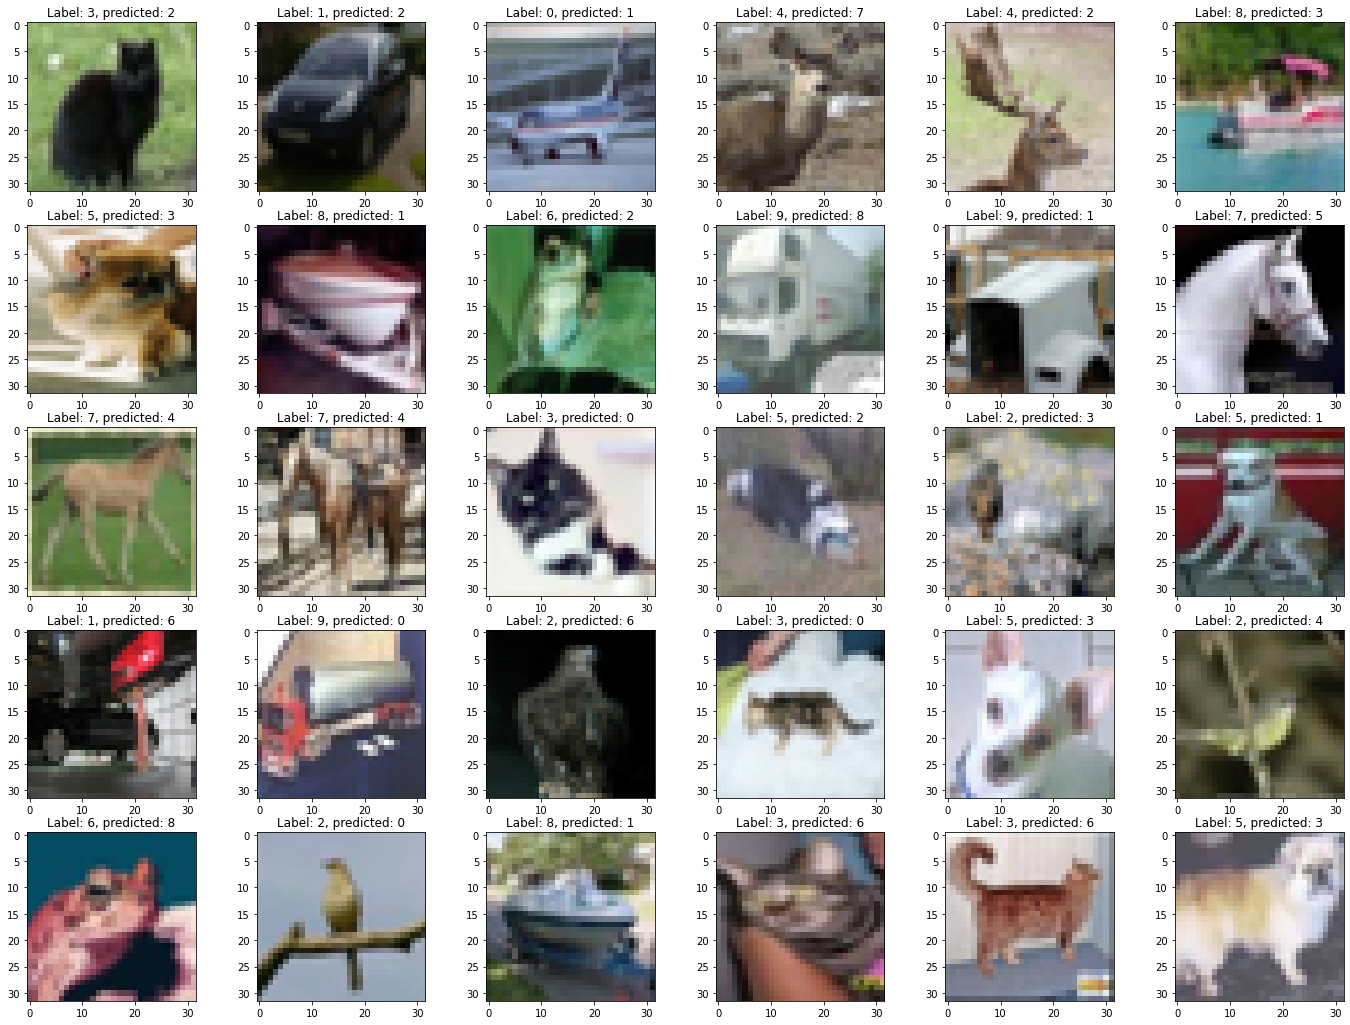

In [14]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(Ypred.shape)
print(Y_test.shape)
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## 8. Define your model, cost function, optimizer, learning rate using SSL Pretext

In [15]:
def my_model_pretext(ishape = (32,32,3),k = 4, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    model_pretext = tf.keras.models.Model(inputs = model_input, outputs = flat)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    return model,model_pretext

In [16]:
model2,model_pretext2 = my_model_pretext()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics = ["accuracy"])
print(model_pretext2.summary())
print(model2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 96)        41568     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 96)        8304

## 9. Define your callbacks (save your model, patience, etc.)

In [18]:
model_name_pretext = "best_model_cifar10_cnn_rot_pretext.h5"
model_name_pretext_no_top = "best_model_cifar10_cnn_rot_pretext_no_top.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_pretext, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 10 Prepare the data to train pretext

In [17]:
# Preparing dataset
X = np.concatenate((X_dev,X_test), axis = 0)
X_augmented = np.zeros((X.shape[0]*4,32,32,3))
X_augmented[::4] = X

X_augmented[1::4] = rotate(X, angle = 90, axes = (1,2))
X_augmented[2::4] = rotate(X, angle = 180, axes = (1,2))
X_augmented[3::4] = rotate(X, angle = 270, axes = (1,2))


Y_augmented = np.zeros((X.shape[0]*4,4), dtype = int)
Y_augmented[::4,0] = 1
Y_augmented[1::4,1] = 1
Y_augmented[2::4,2] = 1
Y_augmented[3::4,3] = 1

## 11. Train your model (on pretext)

In [19]:
model2.fit(X_augmented,Y_augmented,batch_size = 128, epochs = 25, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_split = 0.3, shuffle = True)

Epoch 1/25
1313/1313 [==============================] - 224s 170ms/step - loss: 2.6057 - accuracy: 0.4039 - val_loss: 1.2433 - val_accuracy: 0.5140
Epoch 2/25
1313/1313 [==============================] - 224s 170ms/step - loss: 1.0554 - accuracy: 0.5583 - val_loss: 1.2106 - val_accuracy: 0.4526
Epoch 3/25
1313/1313 [==============================] - 223s 170ms/step - loss: 0.9707 - accuracy: 0.6023 - val_loss: 1.1836 - val_accuracy: 0.4480
Epoch 4/25
1313/1313 [==============================] - 224s 171ms/step - loss: 0.9126 - accuracy: 0.6312 - val_loss: 1.1614 - val_accuracy: 0.4430
Epoch 5/25
1313/1313 [==============================] - 225s 171ms/step - loss: 0.8619 - accuracy: 0.6547 - val_loss: 1.1444 - val_accuracy: 0.4414
Epoch 6/25
1313/1313 [==============================] - 223s 170ms/step - loss: 0.8214 - accuracy: 0.6733 - val_loss: 1.1303 - val_accuracy: 0.4436
Epoch 7/25
1313/1313 [==============================] - 224s 171ms/step - loss: 0.7853 - accuracy: 0.6883 - val_

## 12. Train your model on downstream task

In [20]:
model3, model_pretext3 = my_model_pretext(ishape = (32,32,3),k = 4, lr = 1e-6)
model3.load_weights(model_name_pretext)
model_pretext3.save_weights(model_name_pretext_no_top)

model3, model_pretext3 = my_model_pretext(ishape = (32,32,3),k = 10, lr = 1e-6)
model_pretext3.load_weights(model_name_pretext_no_top)
model_pretext3.trainable = False
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics = ["accuracy"])
print(model3.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 48)        20784     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 96)        41568     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 96)        8304

In [23]:
model3.fit(X_train,Y_train_oh,batch_size = 128, epochs = 10, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/10
293/293 [==============================] - 14s 48ms/step - loss: 2.1691 - accuracy: 0.3651 - val_loss: 2.1723 - val_accuracy: 0.3261
Epoch 2/10
293/293 [==============================] - 14s 48ms/step - loss: 2.1440 - accuracy: 0.3753 - val_loss: 2.1512 - val_accuracy: 0.3171
Epoch 3/10
293/293 [==============================] - 14s 48ms/step - loss: 2.1207 - accuracy: 0.3794 - val_loss: 2.1308 - val_accuracy: 0.3319
Epoch 4/10
293/293 [==============================] - 14s 48ms/step - loss: 2.0980 - accuracy: 0.3879 - val_loss: 2.1113 - val_accuracy: 0.3517
Epoch 5/10
293/293 [==============================] - 14s 48ms/step - loss: 2.0769 - accuracy: 0.3931 - val_loss: 2.0929 - val_accuracy: 0.3506
Epoch 6/10
293/293 [==============================] - 15s 51ms/step - loss: 2.0574 - accuracy: 0.3924 - val_loss: 2.0781 - val_accuracy: 0.3447
Epoch 7/10
293/293 [==============================] - 15s 51ms/step - loss: 2.0388 - accuracy: 0.3950 - val_loss: 2.0609 - val_accuracy:

In [24]:
model_pretext3.trainable = True
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics = ["accuracy"])

In [26]:
model3.fit(X_train,Y_train_oh,batch_size = 128, epochs = 5, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/5
293/293 [==============================] - 51s 173ms/step - loss: 0.9710 - accuracy: 0.6635 - val_loss: 1.0371 - val_accuracy: 0.6388
Epoch 2/5
293/293 [==============================] - 52s 176ms/step - loss: 0.9595 - accuracy: 0.6693 - val_loss: 1.0273 - val_accuracy: 0.6444
Epoch 3/5
293/293 [==============================] - 54s 186ms/step - loss: 0.9500 - accuracy: 0.6702 - val_loss: 1.0244 - val_accuracy: 0.6439
Epoch 4/5
293/293 [==============================] - 53s 180ms/step - loss: 0.9406 - accuracy: 0.6753 - val_loss: 1.0058 - val_accuracy: 0.6510
Epoch 5/5
293/293 [==============================] - 52s 179ms/step - loss: 0.9295 - accuracy: 0.6778 - val_loss: 1.0112 - val_accuracy: 0.6470


## 13. Test your model on the test and extract relevant metrics

In [28]:
model3.load_weights(model_name_pretext)
metrics = model3.evaluate(X_test,Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.9984 - accuracy: 0.6593
Categorical cross-entropy: 0.9983973503112793
Accuracy: 0.6593000292778015
